# Does Form follow Function?
### Building functions Classification using data from the City of Hamburg

Data Science for Spatial Systems Coursework - Melanie Imfeld - 04/2018 <br>
<br>
Data analysis: Python Version 3.6.2 <br>
Preprocessing: QGIS Version Las Palmas 2.18

<hr style= "height: 1px;">

# 1) Introduction and objectives

The architect and skyscraper pioneer Louis Sullivan coined the famous axiom “form follows function” and with the rise of Modernism in the 1920s, it became the touchstone for many architects. Although Sullivan meant advocate against ornamentation in architecture, it can also be interpreted as the relation between architectural shape and human activities. 

Indeed many buildings are restricted by their function: Residential building footprints can only be of limited depth to ensure natural lighting. Industrial buildings often are of a simple shape as they do not have any representative function besides their industrial purpose. The aim of this coursework is to investigate if the function of a building can be predicted based on its geometrical attributes and year built by using supervised machine learning techniques. Supervised learning consists in learning the link between two datasets: the observed data X and an external variable y that we are trying to predict, usually called “target” or “labels”. Extensive data about building functions is rare. Therefore, such machine learning techniques could be used to identify the function of buildings where data is not readily accessible. 

The dataset used in this coursework contains all buildings in the City of Hamburg that were registered in 2016. It includes the polygons, functions, number of floors, as well as the roof and the construction types. The entire GML file can be downloaded  <a href="http://suche.transparenz.hamburg.de/dataset/alkis-liegenschaftskarte-ausgewahlte-daten-hamburg15?forceWeb=true">here</a> and metadata can be found <a href="http://www.adv-online.de/AAA-Modell/ALKIS/broker.jsp?uMen=4ad505ea-127b-b941-2df2-65a572e13d63">here</a>. For the purpose of this analysis some extra features were added in QGIS, which are described in detail in chapter four. They are based on the research put forth by Michael Wurm (2016), who also suggested the use of this dataset and also provided me with Python scripts to read the GML files. 


### Overview Notebook

1. Introduction and objective
2. Metadata
3. Cleaning and reshaping the dataset
4. Exploring the variables
    * 4.1 Target variable
    * 4.2 Independent variables
    * 4.3 Key findings after initial analysis
5. Preparing the data for classification
    * 5.1 Dummy variables
    * 5.2 Manual feature selection
6. K-nearest Neighbor Classifier
    * 6.1 Initial test runs
    * 6.2 Inital results
    * 6.3 Gridsearch
7. Decision Tree Classifier
    * 7.1 Initial test runs
    * 7.2 Gridsearch and pipelining
8. Random Forest Classifier
    * 8.1 Gridsearch and pipelining
9. Key findings
10. References

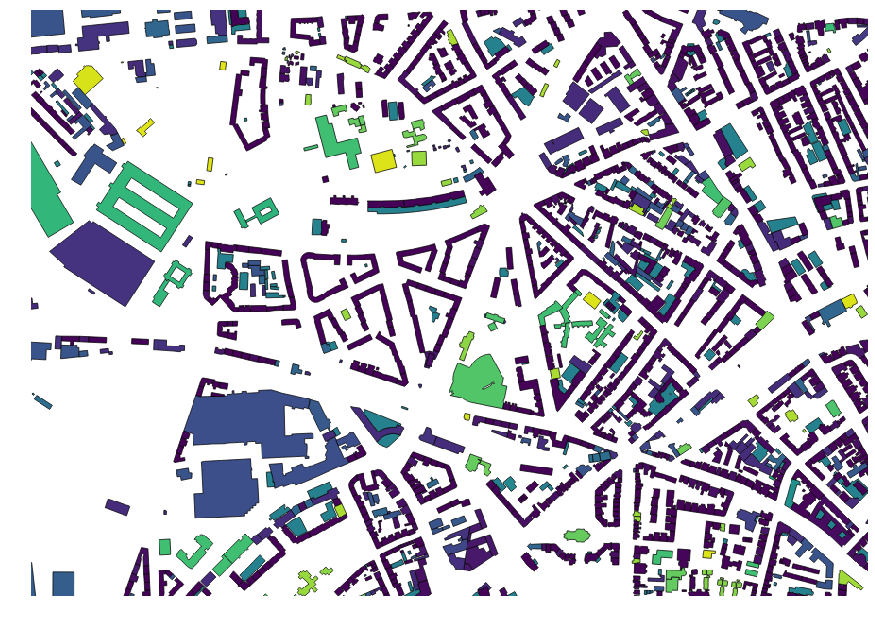

In [321]:
#run this to see what the building polygons look like:
from PIL import Image
file = Image.open("_basedata/excerpt.png")
f = plt.figure(figsize=(15,15))
mgplot = plt.imshow(file)
plt.axis('off')
plt.show()

# 2) Metadata

Modules used:
- Pandas 0.20.3
- PIL 4.2.1
- Matplotlib 2.0.2
- Seaborn 0.8.0
- Sklearn 0.19.0
- mpl_toolkits.axes_grid1 (Version unknown)
- Graphviz 0.8.2

In [2]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
#set maximal rows to print
pd.set_option('display.max_rows', 300)
%matplotlib inline

In [3]:
#sets the display of float values to 3 decimal places
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [4]:
#import all metadata
roof_key = pd.read_csv('_basedata/roof_key.txt')
functions_key = pd.read_csv('_basedata/functions_key.txt')
typo_key = pd.read_csv('_basedata/typology_key.txt')

First inspect if all datasets loaded in properly:

In [325]:
typo_key.head()

,type,value
0,Single detached building,1100
1,Detached building block,1200
2,Single garage,1300
3,Double garage,1400
4,Collective garage,1500


In [326]:
roof_key.head()

,name,type
0,Flat roof,1000
1,Single pitch roof,2100
2,Shifted single pitch roof,2200
3,Double pitch roof,3100
4,Hip roof,3200


In [327]:
functions_key.head()


,Unnamed: 0,type,value
0,0,Wohngebaeude,1000
1,1,Wohnhaus,1010
2,2,Wohnheim,1020
3,3,Kinderheim,1021
4,4,Seniorenheim,1022


# 3) Clean and reshape dataset

Now let's load in the main dataset:

In [12]:
buildings = pd.read_csv('_basedata/buildings.csv',sep='\t', index_col=0)

/Users/myveryself/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [13]:
buildings.head()

,FUNC,STOR,ROOF,AREA,CONS,YEAR,PERI,VERT,CENX,CENY,DENS,RADR
0,2700,1.000,3100.000,113.000,nan,NaN,43,4,582582,5921339,4.000,0.597
1,2741,1.000,3100.000,596.000,nan,NaN,106,4,582556,5920798,4.000,0.402
2,2463,1.000,3100.000,107.000,nan,NaN,43,4,583171,5920187,1.000,0.489
3,2463,1.000,3100.000,51.000,nan,NaN,29,4,583387,5920419,6.000,0.690
4,2741,1.000,3100.000,104.000,nan,NaN,47,11,582886,5920464,4.000,0.345


In [14]:
#inspect datatypes
buildings.dtypes

FUNC      int64
STOR    float64
ROOF    float64
AREA    float64
CONS    float64
YEAR     object
PERI      int64
VERT      int64
CENX      int64
CENY      int64
DENS    float64
RADR    float64
dtype: object

In [15]:
#look at the summary stats:
buildings.describe()


,FUNC,STOR,ROOF,AREA,CONS,PERI,VERT,CENX,CENY,DENS,RADR
count,363310.000,357678.000,311076.000,363309.000,196168.000,363310.000,363310.000,363310.000,363310.000,363310.000,363310.000
mean,1481.868,1.623,2607.156,189.403,1711.631,50.907,8.505,567728.131,5935836.759,4.181,0.483
std,672.119,1.208,1599.623,662.842,586.499,49.107,12.039,7690.457,7732.593,2.613,0.163
min,1000.000,1.000,1000.000,0.000,0.000,3.000,3.000,548689.000,5917222.000,0.000,0.000
25%,1010.000,1.000,1000.000,37.000,1100.000,26.000,4.000,562127.000,5929928.000,3.000,0.387
50%,1010.000,1.000,3100.000,83.000,2100.000,39.000,6.000,567789.000,5936906.000,4.000,0.495
75%,2140.000,2.000,3100.000,161.000,2200.000,57.000,9.000,573857.000,5941835.000,5.000,0.602
max,9998.000,29.000,9999.000,69763.000,2500.000,2464.000,1875.000,587610.000,5954873.000,54.000,1.150


### Clean up YEAR column containing strings

In [16]:
buildings['YEAR'] = buildings['YEAR'] .astype(str).str.replace('\D', '')
buildings.iloc[:,5]
buildings['YEAR'] = buildings['YEAR'].str[-4:]
buildings['YEAR'] = buildings['YEAR'] .replace('','0')
buildings['YEAR']= buildings['YEAR'] .astype(int)


#check if string was transformed to integer
buildings.dtypes

FUNC      int64
STOR    float64
ROOF    float64
AREA    float64
CONS    float64
YEAR      int64
PERI      int64
VERT      int64
CENX      int64
CENY      int64
DENS    float64
RADR    float64
dtype: object

# 4) Exploring the variables

In a first step, we will look at all interesting variables and their relation to our target. Find below a brief description of the variables in the dataset:

|Name| Type| Description|
|:------|:------|:------|
|FUNC|cat|Building functions, 170 different types|
|STOR|int, ordinal|Number of building floors|
|ROOF|cat|Roof types, 15 different types|
|AREA|float|Area of building footprint in square meters|
|CONS|cat|Construction types, 10 different types|
|YEAR|int, ordinal|Year built|
|PERI|float|Building perimeter|
|VERT|int, ordinal|A measure of complexity: Number of vertices (building corners)|
|DENS|int, ordinal|A measure of density: Number of building polygons within the radius of 20 meters buffer from each building center|
|RADR|float|A measure of 'squareness': The proportion of the radius of a polygon-enclosed (r_inn) and enclosing circle (r_out) $\frac{r_inn}{r_out}$ |
|CENX|coord|Easting coordinate ETRS89 UTM32|
|CENY|coord|Northing coordinate ETRS89 UTM32|

## 4.1) Target variable : Building functions

In this section, we will look at the variable we want to predict. In the metadata it is stated that buildings are classified according to the information accessible. In our case, buildings are assigned to different hierarchical orders, indicating less information on some buildings. An example:
- 1000 : 1st hierarchical order (should not be assigned) <br>
- 1100 : 2nd hierarchical order <br>
- 1010 : 3nd hierarchical order <br>
- 1011 : lowest hierarchical order (should be assigned whenever possible)

In [17]:
#count frequency of functions
functions = pd.DataFrame(buildings.FUNC.value_counts())
functions = functions.reset_index()
functions

len(functions)

170

In [18]:
#Let's merge the functions with the key to understand what they are
functions = pd.merge(functions, functions_key, left_on=['index'], right_on=['value'], how='left')

#there will be too many, let's limit the results to the classes that contain more than 200 counts
functions = functions[functions.FUNC > 200]
functions.head()

,index,FUNC,Unnamed: 0,type,value
0,1010,178845,1.000,Wohnhaus,1010.000
1,2463,60651,101.000,Garage,2463.000
2,1313,36319,24.000,Gartenhaus,1313.000
3,1000,16703,0.000,Wohngebaeude,1000.000
4,1100,11881,8.000,Gemischt genutztes Gebaeude mit Wohnen,1100.000


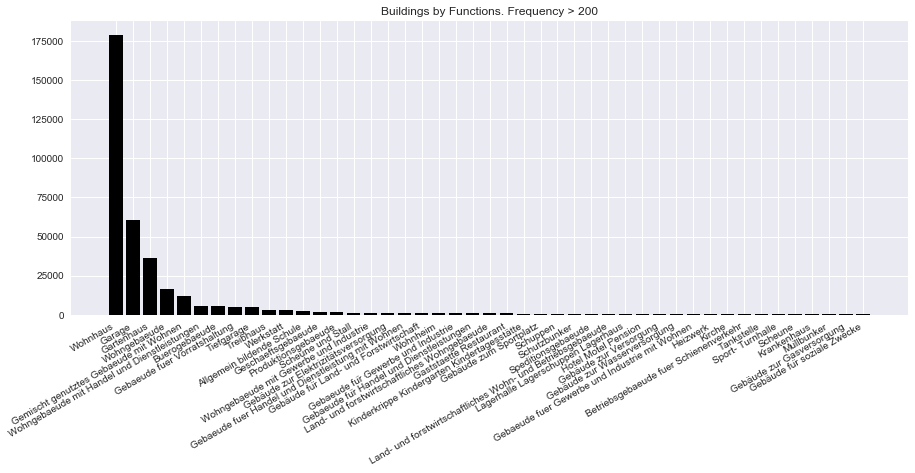

In [19]:
#a function to make drawing bar charts a bit faster
def draw_bar(data, col, title, label):
    sns.set(style="darkgrid")
    fig1=plt.figure(3, figsize=(15,6))
    plt.bar(range(len(data)), data[col],width=0.8,tick_label=label, color ='k')
    plt.title(title)
    fig1.autofmt_xdate()
    
functionplot = draw_bar(functions,'FUNC', 'Buildings by Functions. Frequency > 200', functions.type)

### We can see that the data is very skewed. Out of the 170 classifications as expected 90% are residential buildings, followed by garages, and summer houses. We can guess that the classification algorithm will work better on the  building functions that have more data than those that have little data.

A popular approach towards solving class imbalance problems is to bias the classifier so that it pays more attention to the positive instances. This can be done, for instance, by increasing the penalty associated with misclassifying the positive class relative to the negative class. Another approach is to preprocess the data by oversampling the majority class or undersampling the minority class in order to create a balanced dataset. Some more info <a href="https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/">here</a>.


As mentioned before, we also know that the classification contains different hierarchical orders. This can be a problem, because buildings with a first order label are regarded as different from buildings of the second, third or fourth order. For those reasons, we will try to balance the dataset by aggregating and subsetting.



### Let's aggregate building functions to the highest hierarchical level. Don't run the code below, it will run for a very long time!

These are the new, aggregate labels:
- 1000: Residential Apartment Building
- 1100: Residential Mixed Use
- 2000: Commerical retail & office
- 2100: Commerical industrial: e.g. plants
- 2400: Infrastructure: e.g. trainstations, parking garages
- 2500: Supply: e.g, water, energy, gas
- 2600: Waste: waste water, solid waste
- 2700: Agriculture: e.g barn 
- 9999: Else

In [ ]:
sample = buildings

#iterate through FUNC column and append a new column
for index, row in enumerate(sample.FUNC):
  
    #if string contains 10 in position 1 and 2:
    if str(row)[:2] == '10':
        #print('yes')
        sample.loc[index,'FUNC2']=1000
  
    elif str(row)[:2] == '11':
        #print('yes')
        sample.loc[index,'FUNC2']=1100
    
    elif str(row)[:2] == '20':
        #print('yes')
        sample.loc[index,'FUNC2']=2000
        
    elif str(row)[:2] == '21':
        #print('yes')
        sample.loc[index,'FUNC2']=2100
    
    elif str(row)[:2] == '24':
        #print('yes')
        sample.loc[index,'FUNC2']=2400
    
    elif str(row)[:2] == '25':
        #print('yes')
        sample.loc[index,'FUNC2']=2500
    
    elif str(row)[:2] == '26':
        #print('yes')
        sample.loc[index,'FUNC2']=2600
    
    elif str(row)[:2] == '27':
        #print('yes')
        sample.loc[index,'FUNC2']=2700
    
    elif str(row)[:2] == '30':
        #print('yes')
        sample.loc[index,'FUNC2']=3000
    
    elif str(row)[:2] == '32':
        #print('yes')
        sample.loc[index,'FUNC2']=3200
        
    else:
        #print('no')
        sample.loc[index,'FUNC2']=9999

In [ ]:
sample.head()

### Also, the dataset does not differentiate between multifamily housing and single family housinf. Let's assume that all buildings classified as 10xx with an area under 100sqm and 1 floor cannot be apartment buildings. The new class will be labelled '1010'.

In [ ]:
#assign a value of 1010 to the single family homes:
sample.loc[(sample['AREA'] <= 100) & (sample['STOR'] <= 1) & (sample['FUNC2'] == 1000), 'FUNC2'] = 1010

In [ ]:
#check:
sample[sample['FUNC2'] == 1010]

Read out the data to csv to skip this lengthy code above later:

In [22]:
sample.to_csv('_basedata/buildings_agg.csv',sep='\t')

### Read in aggragate file to save time

In [21]:
buildings_agg = pd.read_csv('_basedata/buildings_agg.csv',sep='\t', index_col=0)
buildings_agg.dtypes

FUNC       int64
STOR     float64
ROOF     float64
AREA     float64
CONS     float64
YEAR       int64
PERI       int64
VERT       int64
CENX       int64
CENY       int64
DENS     float64
RADR     float64
FUNC2    float64
dtype: object

In [183]:
len(buildings_agg)

363310

We will count the functions again:

In [23]:
functions2=pd.DataFrame(buildings_agg.FUNC2.value_counts())

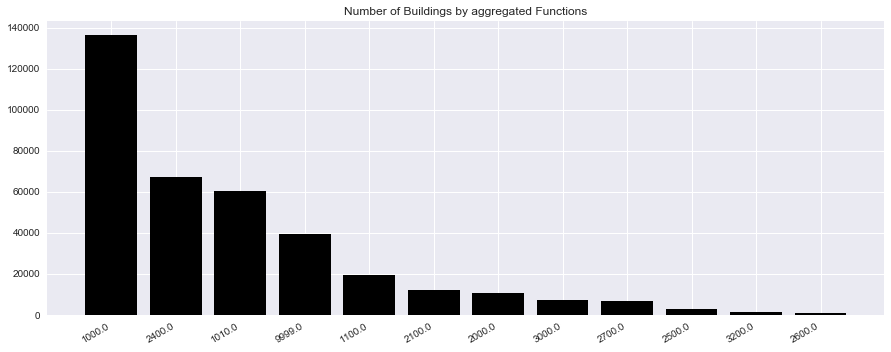

In [24]:
draw_bar(functions2,'FUNC2', 'Number of Buildings by aggregated Functions', functions2.index)

In [25]:
functions2.head()

,FUNC2
1000.000,136360
2400.000,66996
1010.000,60209
9999.000,39382
1100.000,19322


### We will only keep the top five building fuction classes. Smaller classes might create problems later when we split the data into train and test set.

In [26]:
#select top functions
buildings_agg = buildings_agg.loc[buildings_agg['FUNC2'].isin([1000,1010,2400,2100,1100])]
#reset the index
buildings_agg = buildings_agg.reset_index(drop=True)

In [396]:
len(buildings_agg)

295194

We will also delete zero values. `YEAR` and `CONS` zero values are still in there, we will look at these later.

In [27]:
#drop all zero values except years and construction
buildings_agg = buildings_agg.dropna()
len(buildings_agg)

190822

Not surprisingly, the dataset was reduced significantly after dropping the zero values.

In [224]:
buildings_agg.tail()

,FUNC,STOR,ROOF,AREA,CONS,YEAR,PERI,VERT,CENX,CENY,DENS,RADR,FUNC2
295189,1100,3.000,1000.000,100.000,2100.000,0,44,16,566079,5939420,5.000,0.546,1100.000
295190,1010,4.000,1000.000,1038.000,2500.000,0,204,27,566797,5938395,2.000,0.073,1000.000
295191,1010,1.000,3100.000,113.000,2100.000,0,47,8,566323,5938998,10.000,0.440,1000.000
295192,1010,4.000,3100.000,605.000,2500.000,0,133,10,566520,5938537,1.000,0.246,1000.000
295193,1010,5.000,3200.000,495.000,2400.000,0,102,35,567301,5938060,3.000,0.397,1000.000


In [226]:
#check out number of occurences per class again
buildings_agg.FUNC2.value_counts()

1000.000    130357
1010.000     41675
1100.000     16892
2400.000      1786
2100.000       112
Name: FUNC2, dtype: int64

## 4.2) Independent variables 

In a next step, we will analyze the independent variables, that is, the variables we will use to predict our target. We will separate `YEAR`, `CONS` and `ROOF` from the analysis of the other features. Let's look at all the other features first:

### Geometry features (AREA, PERI, VERT, RADR, STOR, DENS)

In [28]:
#transform the categorical features from floats into categories to make sure they won't be read as numerical.
buildings_agg["ROOF"] = buildings_agg["ROOF"].astype('category')
buildings_agg["CONS"] = buildings_agg["CONS"].astype('category')
buildings_agg["FUNC2"] = buildings_agg["FUNC2"].astype('category')

Subset the geometry features and and normalize them to make comparison easier.

In [29]:
geom1 = buildings_agg.loc[:, ['AREA','PERI','VERT','RADR','FUNC2', 'STOR','DENS']]

summary_stats = geom1.describe()
stdevs = summary_stats.loc['std']
means = summary_stats.loc['mean']

# Create and add a normalized column for each column to the original dataframe :

for col in geom1.columns:
    print(col)
    if ((col == 'AREA')|(col =='PERI')|(col =='VERT')|(col =='RADR')|(col =='STOR')|(col =='DENS')):
        #print('yes')
        geom1[col + '_nor'] = (geom1[col] - means[col])/ stdevs[col]
            
geom2 = geom1.loc[:, ['AREA_nor','PERI_nor','VERT_nor','RADR_nor', 'STOR_nor','DENS_nor','FUNC2']]


AREA
PERI
VERT
RADR
FUNC2
STOR
DENS


Let's have a look at the summary statistics to see the impact of normalizing the values

In [229]:
geom1.describe()

,AREA,PERI,VERT,RADR,STOR,DENS,AREA_nor,PERI_nor,VERT_nor,RADR_nor,STOR_nor,DENS_nor
count,190822.000,190822.000,190822.000,190822.000,190822.000,190822.000,190822.000,190822.000,190822.000,190822.000,190822.000,190822.000
mean,162.361,53.950,9.501,0.471,1.906,4.136,0.000,-0.000,-0.000,-0.000,0.000,0.000
std,229.732,33.300,10.124,0.152,1.195,2.249,1.000,1.000,1.000,1.000,1.000,1.000
min,3.000,6.000,3.000,0.001,1.000,0.000,-0.694,-1.440,-0.642,-3.088,-0.758,-1.839
25%,75.000,36.000,4.000,0.379,1.000,3.000,-0.380,-0.539,-0.543,-0.609,-0.758,-0.505
50%,111.000,46.000,8.000,0.493,2.000,4.000,-0.224,-0.239,-0.148,0.139,0.079,-0.061
75%,173.000,59.000,11.000,0.588,2.000,5.000,0.046,0.152,0.148,0.763,0.079,0.384
max,34458.000,1521.000,1272.000,1.000,16.000,28.000,149.285,44.055,124.700,3.470,11.795,10.612


Boxplots grouped by building function will visualize the summary statistics (Note: the outliers are excluded here!):

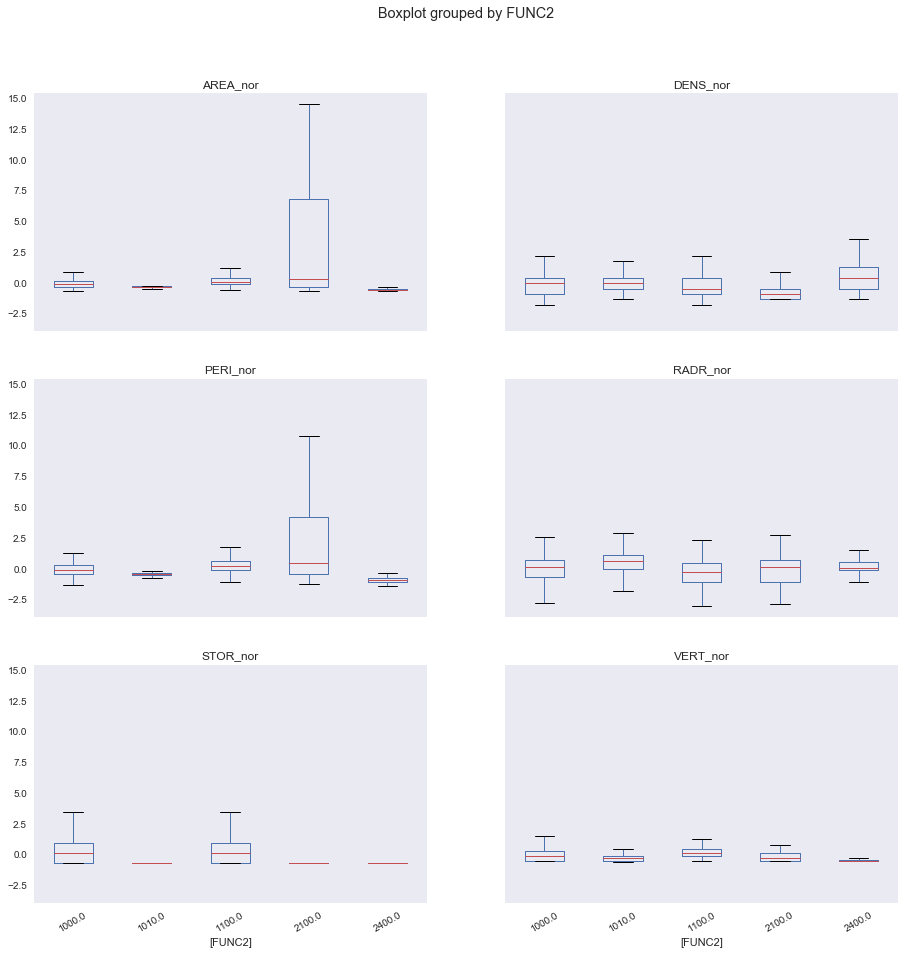

In [30]:
#https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.boxplot.html#pandas.DataFrame.boxplot
sns.set(style="darkgrid")
boxplot_geom = geom2.boxplot(by='FUNC2', figsize=(15,15), grid=False, showfliers=False, rot=30)

### Correlations between geometry features 

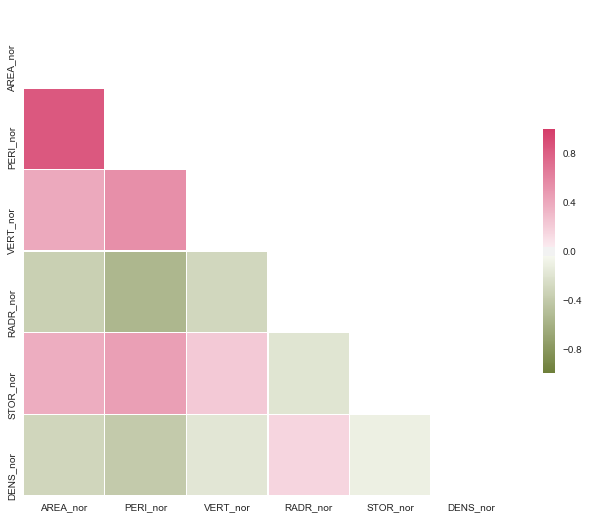

In [314]:
sns.set(style="white")

# Compute the correlation matrix
corr = geom2.corr(method='pearson')

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Custom diverging colormap
cmap = sns.diverging_palette(100, 0, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1,vmin=-1,center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5})

The correlation matrix suggests that there a both positive and negative correlations. We can verify that in a scatter plot. The scatter plot will also visualize the relationship between the independent variables and the building functions as well as the distribution types (normal, skewed, etc.).

In [36]:
from pandas.plotting import scatter_matrix

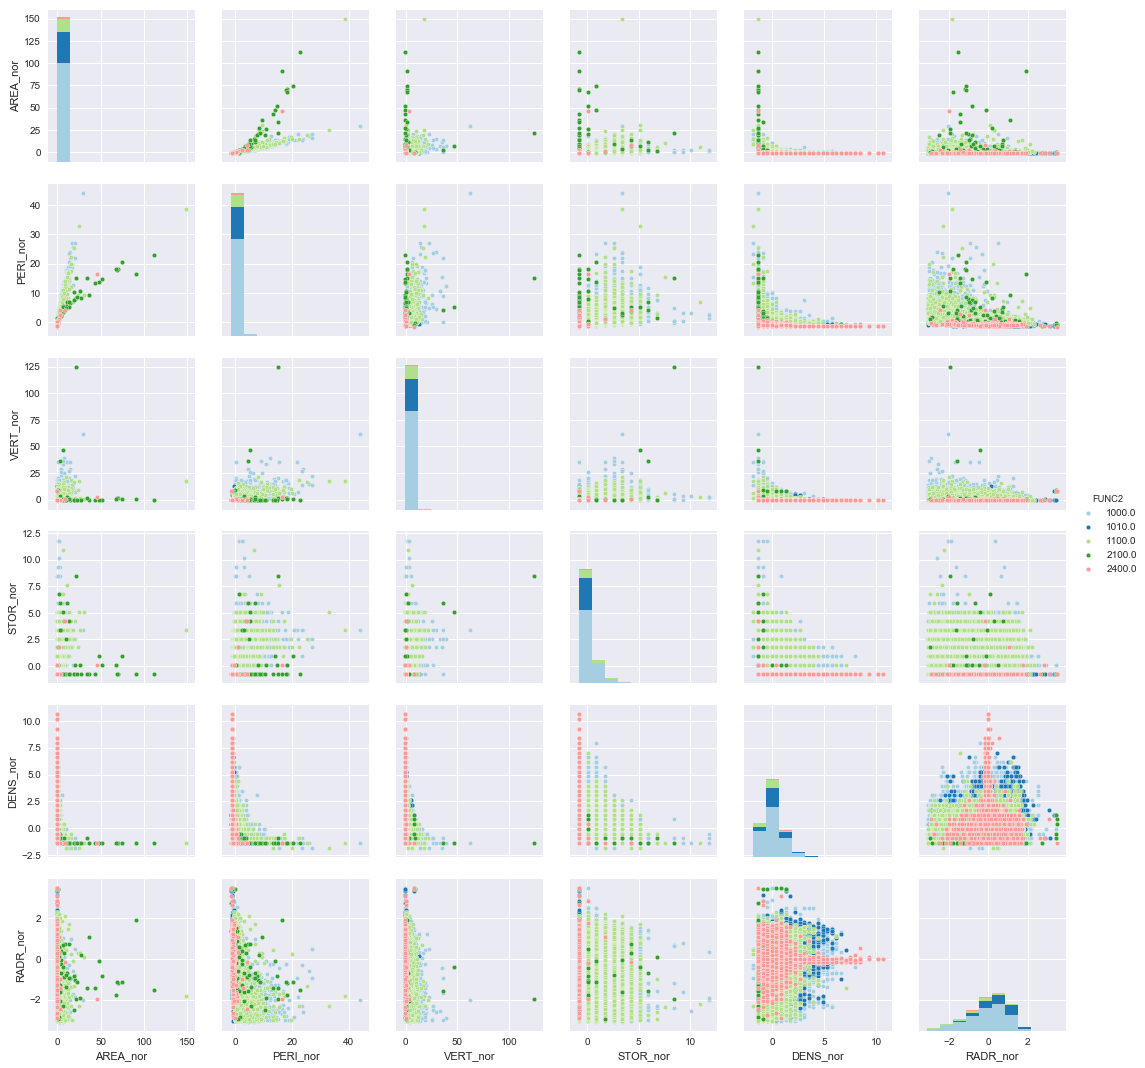

In [315]:
sns.set(style="darkgrid", palette="Paired")
g = sns.pairplot(geom2, vars=["AREA_nor", "PERI_nor", "VERT_nor", "STOR_nor", "DENS_nor", "RADR_nor"], hue="FUNC2",plot_kws={"s": 20})

### Year built (YEAR)

Hamburgs history dates back to the 8th century. The name „Hammaburg“ appeared first around the year 832 after Christ. We will therefore exclude buildings that are built before the year 800 as well as those that presumably were built in the future.

In [31]:
#subset years
year = buildings_agg.loc[:,['YEAR', 'FUNC2']]

#select and inspect them
year = year[(year.YEAR != 0)] 
year = year[(year.YEAR > 800)]
year = year[(year.YEAR < 2018)]
year.head()

,YEAR,FUNC2
4,2015,1000.000
5,1987,1000.000
11,2009,1010.000
12,2014,1010.000
13,1933,1000.000


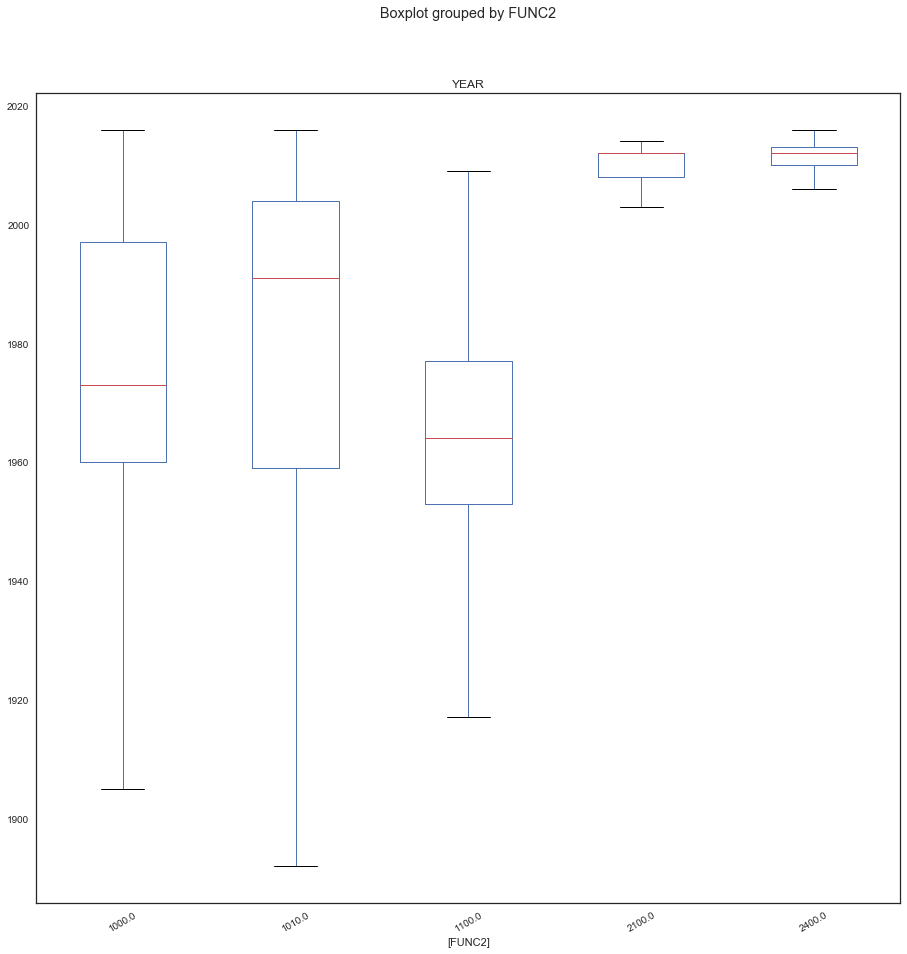

In [32]:
#make a boxplot of the years
sns.set(style="white")
year.boxplot(by='FUNC2', figsize=(15,15), grid=False, showfliers=False, rot=30)

The spread indicates that `YEAR` could be a good predictor! We will also try a different kind of visualization:

In [36]:
j = pd.DataFrame(year.groupby(['YEAR','FUNC2']).size())
y = j.unstack()
y.head()

0                                    
FUNC2 1000.000 1010.000 1100.000 2100.000 2400.000
YEAR                                              
1009     1.000      nan      nan      nan      nan
1010       nan    1.000      nan      nan      nan
1028       nan      nan    1.000      nan      nan
1032       nan      nan    1.000      nan      nan
1043     1.000      nan      nan      nan      nan

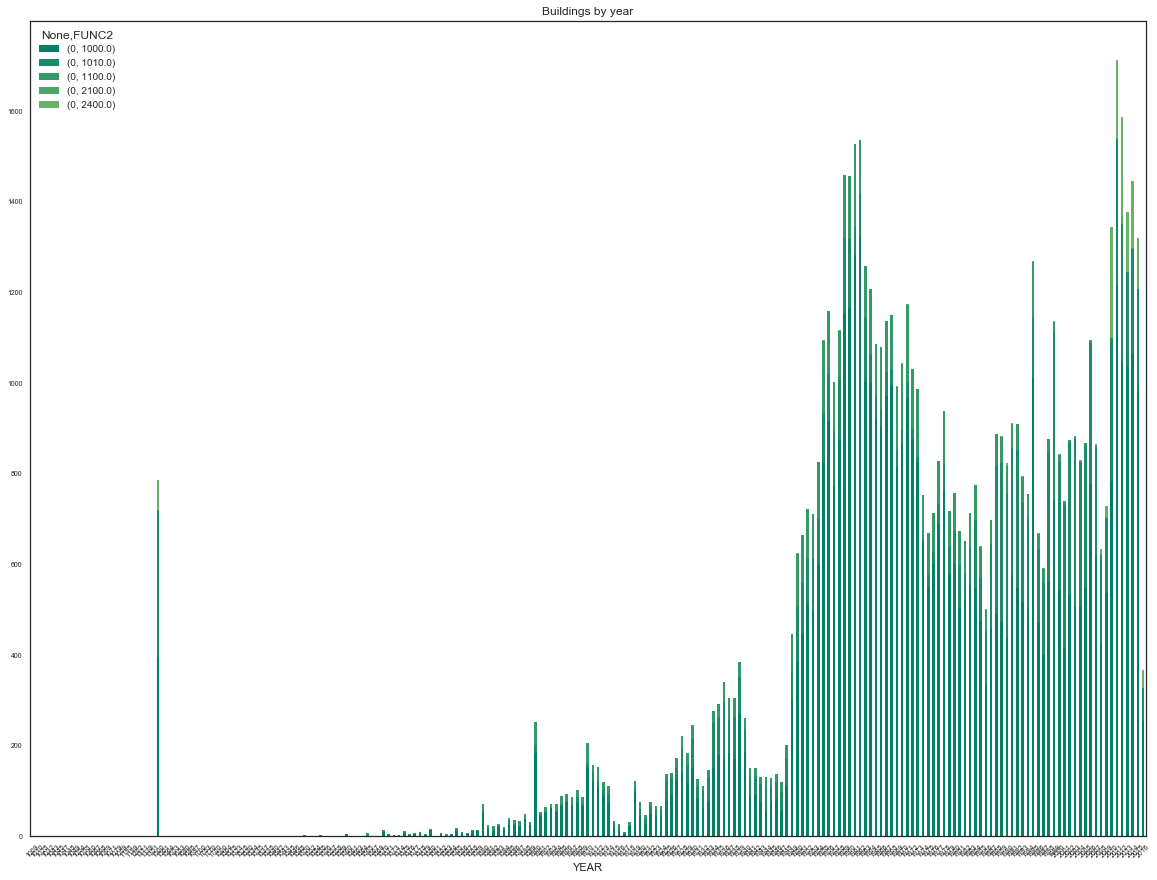

In [57]:
colors = plt.cm.summer(np.linspace(0, 1, 11))
y.plot(kind='bar', stacked=True, figsize=(20, 15), color=colors, rot=45, fontsize=7, title= 'Buildings by year')

The unrealistic years are also excluded from the main dataset:

In [51]:
#subset by year
buildings_agg  = buildings_agg [(buildings_agg.YEAR > 800)]
buildings_agg  = buildings_agg [(buildings_agg.YEAR < 2018)]

In [58]:
#Let's check the length again
len(buildings_agg)

73040

### Rooftype (ROOF) 

In [59]:
#define a function to draw normalized, stacked bars
def draw_stackedbar_norm(data, title, labels, sub):
    sns.set(style="darkgrid")
    x = data.div(data.sum(axis=1), axis=0)
    colors1 = plt.cm.summer(np.linspace(0, 1, sub))
    ax = x.plot(kind='bar', stacked=True, figsize=(20, 10), color=colors1, fontsize=15, title=title)
    ax.set_xticklabels(labels, rotation=45)
    ax.legend(loc=4)

In [60]:
#A way to show summary statistics of categorical values
cat = pd.Categorical(buildings_agg.ROOF)
cat.describe()

,counts,freqs
categories,,
1000.000,13017,0.178
2100.000,787,0.011
2200.000,30,0.000
3100.000,35218,0.482
3200.000,13685,0.187
3300.000,319,0.004
3400.000,7207,0.099
3500.000,334,0.005
3600.000,1,0.000


In [61]:
#Subset the roofs
roof = buildings_agg.loc[:,['ROOF', 'FUNC2']]
roof1 = pd.DataFrame(roof.groupby(['FUNC2', 'ROOF']).size().unstack())

In [62]:
roof1.head()

ROOF,1000.0,2100.0,2200.0,3100.0,3200.0,3300.0,3400.0,3500.0,3600.0,3700.0,3800.0,3900.0,4000.0,5000.0,9999.0
FUNC2,,,,,,,,,,,,,,,
1000.000,10696.000,737.000,27.000,24941.000,9006.000,87.000,5189.000,272.000,1.000,9.000,12.000,3.000,215.000,913.000,826.000
1010.000,218.000,28.000,1.000,7897.000,3580.000,230.000,513.000,53.000,nan,1.000,1.000,nan,41.000,96.000,66.000
1100.000,1023.000,nan,nan,2309.000,1049.000,nan,1504.000,nan,nan,nan,nan,nan,10.000,194.000,48.000
2100.000,29.000,nan,nan,3.000,1.000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2400.000,1051.000,22.000,2.000,68.000,49.000,2.000,1.000,9.000,nan,nan,1.000,1.000,nan,4.000,1.000


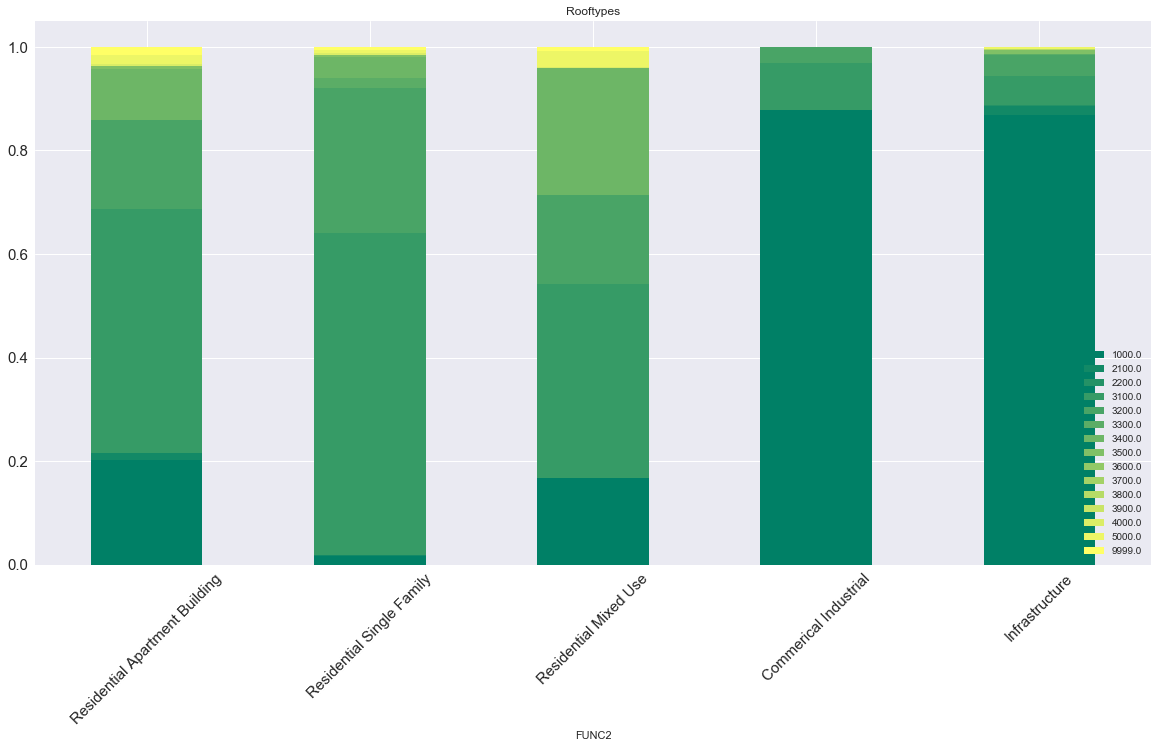

In [63]:
#create labels 
D = ['Residential Apartment Building','Residential Single Family','Residential Mixed Use','Commerical Industrial',
     'Infrastructure']
#draw barchart
draw_stackedbar_norm(roof1, 'Rooftypes', D, 15)

### Construction types (CONS)

In [254]:
#subset construction types:
construction = buildings_agg.loc[:,['CONS', 'FUNC2']]

In [256]:
#create a matrix
construction = pd.DataFrame(construction.groupby(['FUNC2', 'CONS']).size().unstack())
construction.head()

CONS,0.0,1100.0,1200.0,1300.0,1400.0,1500.0,2100.0,2200.0,2400.0,2500.0
FUNC2,,,,,,,,,,
1000.000,nan,14117.000,5341.000,nan,nan,nan,4308.000,10014.000,7469.000,11685.000
1010.000,nan,6115.000,8.000,1.000,1.000,nan,5134.000,1454.000,7.000,5.000
1100.000,nan,1764.000,684.000,nan,nan,nan,155.000,167.000,2323.000,1044.000
2100.000,33.000,nan,nan,nan,nan,nan,nan,nan,nan,nan
2400.000,4.000,14.000,nan,966.000,191.000,36.000,nan,nan,nan,nan


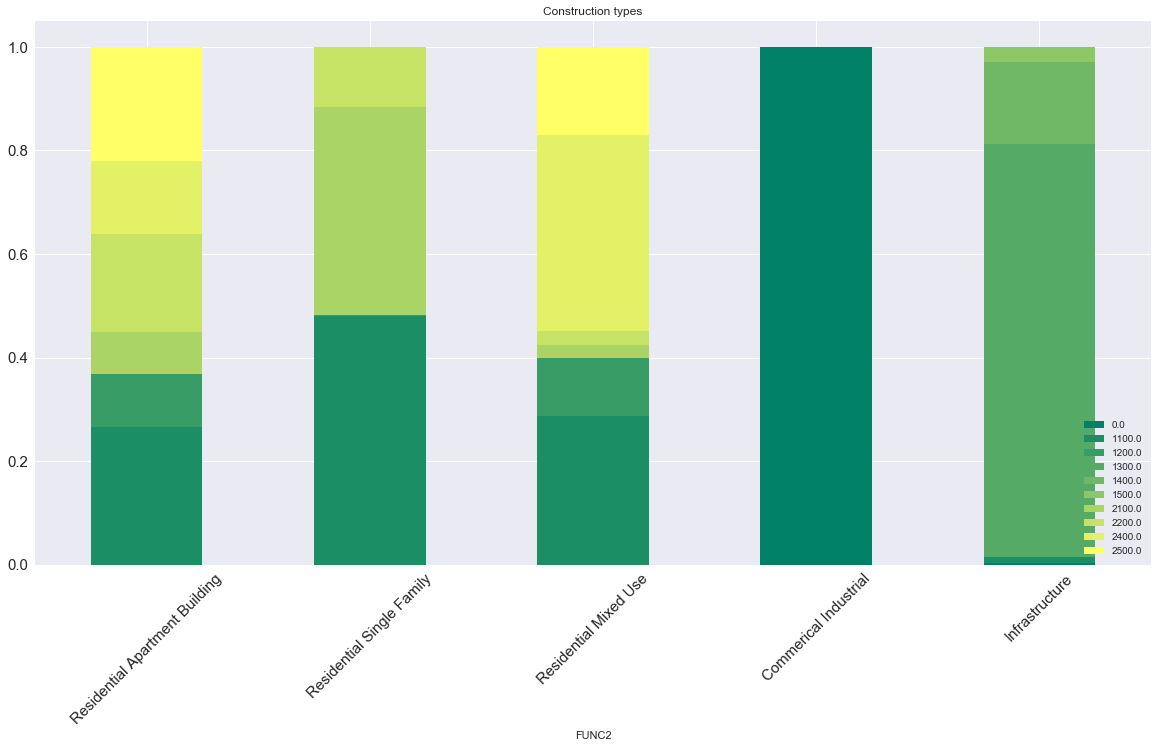

In [257]:
draw_stackedbar_norm(construction, 'Construction types', D, 10)

...Have a look at Commerical Industrial: the zero values seem to cluster there!

## 4.3) Key findings after initial analysis

### Relationship between the features and the building function

### 1000: Residential Apartment Building: 
Their characteristics include a variety of construction and roof types. Since we artificially created this class, their area (mean: 180sqm) and number of floors (mean: 2.18) have a lower bound. Interestingly, the buildings on average were constructed before the residential single family homes.

### 1010: Residential Single Family: 
Single family homes tend to be more 'square' (RADR) than other classes. Equally to the above class, their area and number of floors have a maximum bound. Their characteristics include a variety of construction and roof types and the boxplots indicate a slightly higher mean density than for other classes. This seems somewhat counterintuitive and could be related to the way density was defined previously.

### 1100: Residential Mixed Use: 
Summary statistics indicate that 1100 is quite similar to 1000, which might make it difficult to distinguish later.

### 2100: Commerical Industrial: 
Commercial industrial buildings have a large footprint: 2211sqm on average. In addition, commercial industrial buildings become less complex with larger size than other classes and tend to be in less dense areas. They are characterized by mostly flat roofs and a large number of zero values for the construction type.

### 2400: Infrastructure: 
Infrastructure buildings have a high spread when it comes to geometry features, presumably because they include anything from garage to train station. Since the mean area is around 40sqm, we can assume that most of these features are garages. They also exhibit much less variance when it comes to roof and construction type as their purpose is purely of practical nature.


Summary statistics by building function:

In [272]:
grouped = geom1.groupby('FUNC2')
grouped.AREA.describe()

,count,mean,std,min,25%,50%,75%,max
FUNC2,,,,,,,,
1000.000,130357.000,180.128,182.653,4.000,83.000,129.000,194.000,7068.000
1010.000,41675.000,77.427,14.824,4.000,68.000,79.000,89.000,100.000
1100.000,16892.000,234.147,362.669,12.000,124.000,169.000,246.000,34458.000
2100.000,112.000,2211.161,4692.639,7.000,78.500,215.000,1710.750,25994.000
2400.000,1786.000,40.057,260.586,3.000,16.000,24.000,40.000,10706.000


### Deleting zero values / exclude rare classes
Our original dataset is now remarkably smaller:
1. Original sample size: **363'310**
2. Subset the five most frequent categories: **295'194**
3. Drop zero values except Construction and Years: **190'822**
4. Drop unusual years: **73'040**
    
We will not delete `YEAR` and `CONS` as the data suggests that the missing values are not randomly distributed.
Furthermore many of the geometry features seem related, as they all stem from the same polygon analysis in QGIS. In a later step, features will be selected according to the information they provide. Some columns will therefore drop out as well.

In [259]:
#check classes to be predicted
buildings_agg.FUNC2.value_counts()

1000.000    52934
1010.000    12725
1100.000     6137
2400.000     1211
2100.000       33
Name: FUNC2, dtype: int64

# 5) Preparing the data for classification

Before the data can be used for classification, some adjustments need to be made. The labels we aim to predict and the features we want to use for the prediction need to be separated. In addition, the two categories `ROOF` and `CONS` will need to be transformed into dummy variables to avoid them being interpreted as numerical. The transformer `OneHotEncoder()` will use a method called a binary one-hot (aka one-of-K) coding. Depending on the number of categories `n`, it will split up each value into a binary sequence of columns `n`.

1) split off the labels we aim to classify. As the labels are already numbers there is no need to encode them.

In [68]:
labels = buildings_agg['FUNC2']
len(labels)

73040

2) split off features we base the classification on

In [69]:
#split off features we base the classification on
feat = buildings_agg.loc[:,(buildings_agg.columns != 'FUNC')&(buildings_agg.columns != 'FUNC2')&(buildings_agg.columns != 'CENY')&(buildings_agg.columns != 'CENX')]
len(feat)

73040

## 5.1) Insert dummy variables for categories

In [71]:
from sklearn.preprocessing import OneHotEncoder

In [70]:
#subset categoricals
cat = feat[['ROOF','CONS']]
feat1 = feat.loc[:,(feat.columns != 'ROOF')& (feat.columns != 'CONS')]
feat1 = feat1.reset_index(drop=True)

In [16]:
len(feat1)

73040

In [72]:
#prepare encoder
enc = OneHotEncoder()
#fit it to data
feat_enc = enc.fit_transform(cat)

In [440]:
feat_enc

<73040x25 sparse matrix of type '<class 'numpy.float64'>'
	with 146080 stored elements in Compressed Sparse Row format>

In [20]:
feat_array = feat_enc.toarray()

In [21]:
#join transformed categorical data back to entire dataset
feat1=pd.merge(feat1,pd.DataFrame(feat_array),how='outer',left_index=True,right_index=True)

In [22]:
feat1.tail()

,STOR,AREA,YEAR,PERI,VERT,DENS,RADR,0,1,2,...,15,16,17,18,19,20,21,22,23,24
73035,4.000,913.000,2006,192,37,2.000,0.284,1.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000
73036,4.000,307.000,2006,81,13,3.000,0.495,1.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000
73037,4.000,306.000,2006,81,13,4.000,0.499,1.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000
73038,3.000,228.000,2008,65,10,2.000,0.510,1.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000
73039,1.000,82.000,1992,37,8,2.000,0.649,0.000,0.000,0.000,...,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


## 5.2) Feature selection with univariate statistics

It is useful to filter through the features and reduce dimensionality for the following reasons:

1) Prevent overfitting <br>
2) Reduce computation time <br>
3) Uncover relationships between target and features

There are plenty of methods to do this, in this case `SelectKBest()` selector using univariate statistics is used. By default, it identifies relevant features by using the one way ANOVA F-test. In this case, we will use the Chi-squared statistic since our data is not normally distributed. `SelectKBest` compares the input features `X` with the labels `y` and retains the first `k` features of `X` with the highest scores. A large value suggests that the feature provides important information and will therefore be kept.

<b> To see if feature selection truly provides better outputs, the first classifier is run without and with reduced features.

In [23]:
from sklearn.feature_selection import SelectKBest, chi2, VarianceThreshold

In [24]:
#input the encoded dataset
X, y = feat1, labels

In [25]:
#create selector, set k=8
sel=SelectKBest(chi2, k=15)

feat2 = sel.fit_transform(X, y)

In [26]:
#shows selected features
sel.get_support()

array([ True,  True, False,  True,  True,  True, False,  True, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False,  True,  True, False,  True,  True,
        True,  True, False,  True,  True], dtype=bool)

The Chi2 statistic identified 11 columns as redundant. To doublecheck if the two features were removed:

In [27]:
#doublecheck if features were reduced:
feat2.shape

(73040, 15)

# 6) k-nearest Neighbors classifier (Supervised)

### About k-nearest Neighbors

K-nearest Neigbhbors is a supervised neighbors-based classification for data with discrete, multiclass labels. It compares the distance between a unlabelled point with labelled points and assigns labels based on the shortest Euclidian distance. 'k' specifies how many nearest neigbors we want to identify for the point we want to classify. The majority class of the neighbors will be assigned. Basic parameters that can be adjusted:


| Parameters       |Inputs| What they do        |
| :-------------- |:-------------|:-------------| 
| k     |Integers| No. of neighbors to compare to | 
| weights        |uniform, distance, callable | Weighs neigbors uniformly, based on inverse distance weighting or custom |  
| algorithm      |BallTree, KDTree, Brute, Auto| Different algorithms for searching neighbors| 

## 6.1) Initial test runs

In [77]:
import time
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import metrics

In [31]:
#import the classifier
from sklearn.neighbors import KNeighborsClassifier

In [78]:
#subset data without feature selection
train_d, test_d, train_lab, test_lab = train_test_split(feat1, labels)

In [81]:
#with feature selection
train_d_fs, test_d_fs, train_lab_fs, test_lab_fs = train_test_split(feat2, labels)

In [34]:
train_d.shape,test_d.shape

((54780, 32), (18260, 32))

In [35]:
train_d_fs.shape,test_d_fs.shape

((54780, 15), (18260, 15))

In [36]:
#fit data without feature selection
knn1 = KNeighborsClassifier(n_neighbors=5)  # creates the kNN classifier, setting it to check the 60 neighbouring points
a = time.time()
knn1.fit(train_d, train_lab)  # executes the classifier on the training dataset
elapsed = time.time()- a
print(knn1,'takes', elapsed, 'seconds to run')

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform') takes 0.30588698387145996 seconds to run


In [37]:
#fit data with feature selection
knn2 = KNeighborsClassifier(n_neighbors=5)  # creates the kNN classifier, setting it to check the 60 neighbouring points
a = time.time()
knn2.fit(train_d_fs, train_lab_fs)  # executes the classifier on the training dataset

elapsed = time.time()- a
print(knn2,'takes', elapsed, 'seconds to run')

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform') takes 0.14782929420471191 seconds to run


mean accuracy score:

In [38]:
knn1.score(test_d, test_lab),knn2.score(test_d_fs, test_lab_fs)

(0.85936473165388827, 0.88105147864184008)

The mean accuracy score is a very imprecise measure. To get a better sense of how well the classifier performed we will look at the detailed summary statistics. In order to obtain the full information, the trained classifier is applied on our test dataset.

In [39]:
knn1_lab_pred = knn1.predict(test_d)
knn2_lab_pred = knn2.predict(test_d_fs)

### Classification_report: the metrics explained


| Parameters       |What they explain |
| :-------------- |:-------------|
| recall     |tp / (tp + fn): correctly labelled (tp) / total labels of that class (tp + fn)| 
| precision  |tp / (tp + fp): lower precision when predictions are scattered |  
| f1-score   |Weighted harmonic mean of precision and recall| 
| support   |Number of occurrences of each class in the correct target values (test_lab)| 

KnN <b> without </b> feature selection:

In [40]:
knn1_cm = metrics.confusion_matrix(test_lab, knn1_lab_pred)
print(metrics.classification_report(test_lab, knn1_lab_pred))

             precision    recall  f1-score   support

     1000.0       0.88      0.94      0.91     13266
     1010.0       0.83      0.89      0.86      3180
     1100.0       0.28      0.07      0.11      1502
     2100.0       0.00      0.00      0.00         7
     2400.0       0.97      0.89      0.93       305

avg / total       0.82      0.86      0.83     18260



/Users/myveryself/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


KnN <b> with </b> feature selection:

In [41]:
knn2_cm = metrics.confusion_matrix(test_lab_fs, knn2_lab_pred)
print(metrics.classification_report(test_lab_fs, knn2_lab_pred))

             precision    recall  f1-score   support

     1000.0       0.89      0.96      0.92     13232
     1010.0       0.89      0.94      0.92      3220
     1100.0       0.23      0.04      0.07      1486
     2100.0       0.00      0.00      0.00         5
     2400.0       0.96      0.84      0.90       317

avg / total       0.84      0.88      0.85     18260



/Users/myveryself/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Depending on the subdivision of test and traindata we might get a warning here stating that 'Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples'. This just means what it says, some labels haven't been assigned.

### The confusion matrix

The confusion matrix, also known as an error matrix, is a 2d array that visualizes of the performance of an algorithm. The sum of each row returns the actual number of occurences in each class and the sum of the colum returns the total of what the classifer predicted.

In [488]:
#knN without feature selection
knn1_cm

array([[12011,   858,   298,     0,     4],
       [ 1211,  2013,     4,     0,     2],
       [ 1229,    71,   241,     0,     0],
       [    0,     0,     0,     8,     0],
       [  119,    90,     0,     2,    99]])

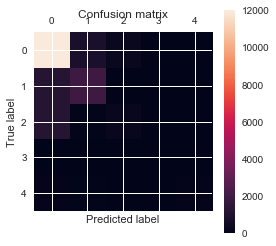

In [489]:
plt.matshow(knn1_cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

The visualisation is not very informative because our sample contains much more predictions in the first column. A way to ease this is to normalize our 2D array. In that way, we visualize the predictions relative to the class size.

In [42]:
def norm_cm(matrix):
    row_sums = matrix.sum(axis=1) # array([ 9, 36, 63])
    new_matrix = np.zeros((5,5))
    for i, (row, row_sum) in enumerate(zip(matrix, row_sums)):
        new_matrix[i,:] = row / row_sum
    return new_matrix

In [193]:
norm_cm(knn1_cm)

array([[  9.15519732e-01,   6.13641548e-02,   2.28119535e-02,
          0.00000000e+00,   0.00000000e+00,   3.04159380e-04],
       [  3.65591398e-01,   6.31336406e-01,   1.22887865e-03,
          0.00000000e+00,   0.00000000e+00,   1.84331797e-03],
       [  7.94520548e-01,   3.97912590e-02,   1.65688193e-01,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.81818182e-01,   8.18181818e-01,   0.00000000e+00],
       [  3.98713826e-01,   2.34726688e-01,   0.00000000e+00,
          3.21543408e-03,   3.21543408e-03,   3.60128617e-01]])

In [61]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def make_cms(cm1,cm2,tit1,tit2,lab):
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,9))
    ax1.set_title(tit1)
    # Display image, `aspect='auto'` makes it fill the whole `axes` (ax3)
    im1 = ax1.imshow(norm_cm(cm1))
    # Create divider for existing axes instance
    divider1 = make_axes_locatable(ax1)
    # Append axes to the right of ax3, with 20% width of ax3
    cax1 = divider1.append_axes("right", size="10%", pad=0.1)
    cbar1 = plt.colorbar(im1, cax1)

    ax1.set_yticklabels(lab)
    ax1.set_xticklabels(lab)

    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('True')

    ax2.set_title(tit2)
    im2 = ax2.imshow(norm_cm(cm2))
    divider2 = make_axes_locatable(ax2)
    cax2 = divider2.append_axes("right", size="10%", pad=0.1)
    cbar2 = plt.colorbar(im2, cax=cax2)

    ax2.set_yticklabels(lab)
    ax2.set_xticklabels(lab)

    plt.show()

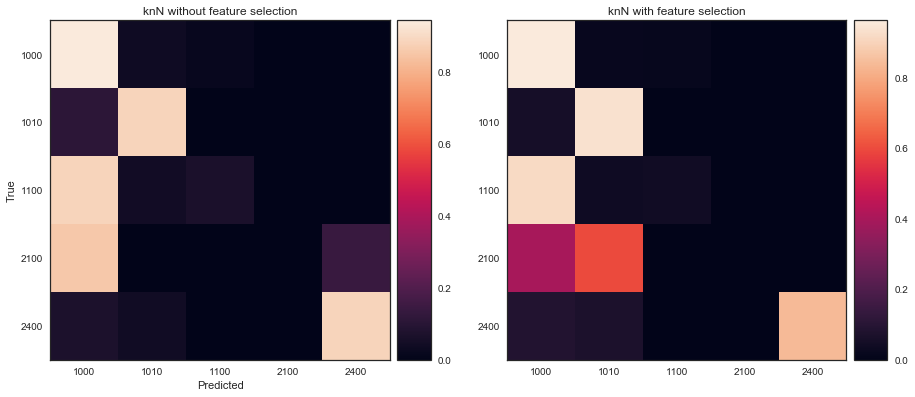

In [121]:
labelsCM = ['A','1000','1010','1100', '2100','2400']
make_cms(knn1_cm,knn2_cm,'knN without feature selection','knN with feature selection',labelsCM)

## 6.2) Initial results knN

### 1000: Residential Apartment Building: 
No difficulty to predict.

### 1010: Residential Single Family: 
No difficulty to predict.

### 1100: Residential Mixed Use: 
Is difficult to predict, too similar?

### 2100: Commerical Industrial: 
knN fails to predict this class.

### 2400: Infrastructure: 
Well predicted: most likely due to significant difference in roof and construction type.

Note: Despite aggregating classes and decreasing the overrepresented class the algorithm is still biased towards the first two groups.

## 6.3) Implementing Gridsearch for knN

Hyper-parameters are parameters that are not directly learnt within estimators. In Scikit-learn they are passed as arguments to the constructor of the estimator classes. The process of finding the right parameters can be automatized with Gridsearch(). It runs over a set of parameters at once and finds the optimal settings. 


| Parameters       |Inputs| 
| :-------------- |:-------------|
| Classifier   |The classifier we want to test| 
| Parameters   |Parameters a given classifier requires |   
| cv   | Takes the train dataset and splits it up in train and test for x consecutive times|

In [46]:
#import gridsearch
from sklearn.model_selection import GridSearchCV

Set the parameters to interate through: <br>
<b> 4 n_neighbors x 2 weights = 6 combinations x 5 consecutive runs

In [44]:
parameters = {'n_neighbors': [5,10,20,30], 'weights':['distance','uniform'],'algorithm': ['auto'] }

In [47]:
knn1_grid_search = GridSearchCV(KNeighborsClassifier(), parameters, cv=2, scoring='accuracy')
knn2_grid_search = GridSearchCV(KNeighborsClassifier(), parameters, cv=2, scoring='accuracy')

In [49]:
#without feature selection
a = time.time()
knn1_grid_search.fit(train_d,train_lab)
elapsed = time.time()- a
print(knn1_grid_search, 'takes', elapsed, 'seconds to run')

GridSearchCV(cv=2, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [5, 10, 20, 30], 'weights': ['distance', 'uniform'], 'algorithm': ['auto']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0) takes 54.248342990875244 seconds to run


In [48]:
#with feature selection
a = time.time()
knn2_grid_search.fit(train_d_fs,train_lab_fs)
elapsed = time.time()- a
print(knn2_grid_search,'takes', elapsed, 'seconds to run')

GridSearchCV(cv=2, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [5, 10, 20, 30], 'weights': ['distance', 'uniform'], 'algorithm': ['auto']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0) takes 25.897830963134766 seconds to run


In [833]:
#results from all 5 runs
results = knn2_grid_search.cv_results_

In [50]:
# takes the parameter with the best mean test score
knn2_grid_search.best_params_

{'algorithm': 'auto', 'n_neighbors': 10, 'weights': 'distance'}

In [123]:
knn1_grid_search.score(test_d, test_lab), knn2_grid_search.score(test_d_fs, test_lab_fs)

(0.96757940854326396, 0.97185104052573934)

In [53]:
# takes the parameter with the best mean test score
knn1_grid_search.best_params_

{'algorithm': 'auto', 'n_neighbors': 10, 'weights': 'distance'}

In [104]:
knn1_gs_lab_pred = knn1_grid_search.predict(test_d)

In [105]:
knn2_gs_lab_pred  = knn2_grid_search.predict(test_d_fs)

In [56]:
print(metrics.classification_report(test_lab, knn1_gs_lab_pred))

             precision    recall  f1-score   support

     1000.0       0.88      0.95      0.92     13266
     1010.0       0.83      0.90      0.86      3180
     1100.0       0.34      0.04      0.07      1502
     2100.0       0.00      0.00      0.00         7
     2400.0       0.97      0.88      0.92       305

avg / total       0.83      0.87      0.84     18260



/Users/myveryself/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [57]:
print(metrics.classification_report(test_lab_fs, knn2_gs_lab_pred))

             precision    recall  f1-score   support

     1000.0       0.89      0.97      0.93     13232
     1010.0       0.90      0.95      0.92      3220
     1100.0       0.23      0.02      0.04      1486
     2100.0       0.00      0.00      0.00         5
     2400.0       0.96      0.84      0.89       317

avg / total       0.84      0.89      0.86     18260



/Users/myveryself/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [124]:
knn1_gs_cm = metrics.confusion_matrix(test_lab, knn1_gs_lab_pred)
knn2_gs_cm = metrics.confusion_matrix(test_lab, knn2_gs_lab_pred)

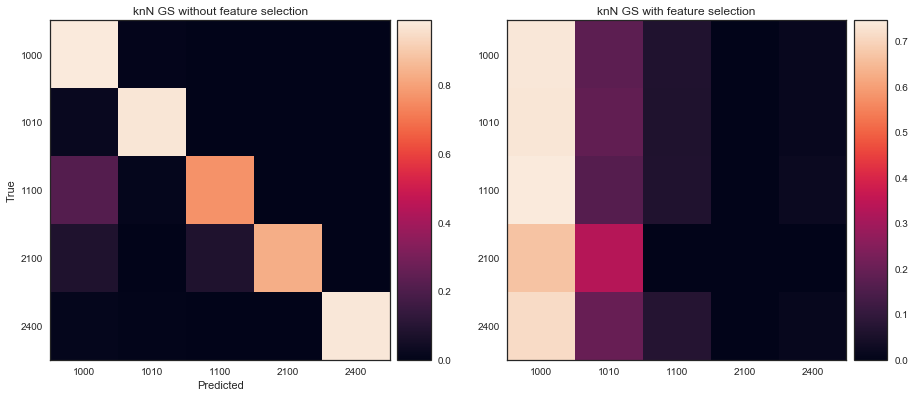

In [125]:
make_cms(knn1_gs_cm,knn2_gs_cm,'knN GS without feature selection','knN GS with feature selection',labelsCM)

The above plots suggest that the manual feature selection does not improve results or even drastically worsen them (see matrix to the right). Therefore, the manually reduced train and test sets will not be included in the following tests.

# 7) Decision Tree classifier

### About the Decision Tree

Decision trees split features into subgroups (e.g. the feature 'gender' into 'female' and 'male'). Out of these subgroups they choose the feature with the most homogenous subgroup, that is, the subgroup that splits our target best as the inital split rule. The process continues until no more useful splits can be found. Classification is able to predict binary labels as well as multiclass labels. It is important to keep in mind that when working with continuous numerical variables, a decision tree looses information when it categorizes variables in different categories. Some parameters explained:


| Parameters       |Inputs| What they do        |
| :-------------- |:-------------|:-------------| 
| criterion     |'gini', 'entropy'| By default 'gini'. Measures the quality, i.e. the homogenity of the subgroups. Gini index = 0: all records in the node belong to the same category. | 
| splitter        |'best', 'random' | The strategy used to choose the split at each node |  
| max_depth     |integer| The 'depth' of the tree: in how many subgroups each feature is split| 
| min_samples_split  |integer or float (for %)| The minimum number of samples required to split an internal node| 
|max_features|integer|The number of features to look at when making the best split. Defaults to all features if not specified| 

## 7.1) Initial test runs

In [73]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

In [74]:
import graphviz

In [79]:
dtree = DecisionTreeClassifier(random_state=0, max_depth=2)
dtree.fit(train_d, train_lab)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

In [80]:
dtree.score(test_d, test_lab)

0.89857612267250819

In [81]:
test_d.shape
test_d.columns

Index(['STOR', 'AREA', 'YEAR', 'PERI', 'VERT', 'DENS', 'RADR'], dtype='object')

In [82]:
lab_dec =['1000','1010','1100','2100','2400']

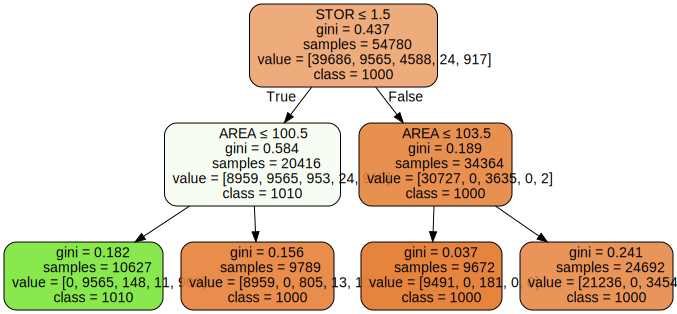

In [83]:
dot_data = export_graphviz(dtree, out_file=None, 
                         feature_names=feat1.columns,  
                         class_names=lab_dec,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)  
graph

With a depth of 2, the Decision Tree Classifier suggests that the features `STOR` (x[0]) , `AREA` (x[1]) and a column from our encoded dummy variables (x[32]) provide the best split into homogenous functional groups. We can see in the classification matrix below that the classifier currently only predicts buildings of type 1000 and 1010.

In [102]:
dtree1_lab_pred = dtree.predict(test_d)

In [70]:
print(metrics.classification_report(test_lab, dtree1_lab_pred))

             precision    recall  f1-score   support

     1000.0       0.90      1.00      0.95     13266
     1010.0       0.90      1.00      0.95      3180
     1100.0       0.00      0.00      0.00      1502
     2100.0       0.00      0.00      0.00         7
     2400.0       0.00      0.00      0.00       305

avg / total       0.81      0.90      0.85     18260



/Users/myveryself/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [71]:
dtree1_cm=metrics.confusion_matrix(test_lab, dtree1_lab_pred)
dtree1_cm

array([[13266,     0,     0,     0,     0],
       [    0,  3180,     0,     0,     0],
       [ 1456,    46,     0,     0,     0],
       [    6,     1,     0,     0,     0],
       [    8,   297,     0,     0,     0]])

## 7.2) Implementing Gridsearch CV and pipelining for Decision Trees

The sklearn.pipeline module chains transformations such as feature selection, hyperparametrization and classifiers. We will include the feature selection `VarianceThreshold()` within the pipe

In [75]:
from sklearn.ensemble import RandomForestClassifier

In [76]:
from sklearn.pipeline import make_pipeline

In [83]:
dtree_pipe = make_pipeline(VarianceThreshold(), DecisionTreeClassifier())
dtree_params = {'decisiontreeclassifier__max_features' : [25, 27, 31, 'auto'],
             'decisiontreeclassifier__max_depth' : [3,4,5, None]}
dtree_grid_search = GridSearchCV(dtree_pipe, dtree_params, cv=3, scoring='accuracy', verbose=2)

In [84]:
a = time.time()
dtree_grid_search.fit(train_d, train_lab)
elapsed = time.time()- a
print(dtree_grid_search,'takes', elapsed, 'seconds to run')

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] decisiontreeclassifier__max_depth=3, decisiontreeclassifier__max_features=25 
[CV]  decisiontreeclassifier__max_depth=3, decisiontreeclassifier__max_features=25, total=   0.1s
[CV] decisiontreeclassifier__max_depth=3, decisiontreeclassifier__max_features=25 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV]  decisiontreeclassifier__max_depth=3, decisiontreeclassifier__max_features=25, total=   0.1s
[CV] decisiontreeclassifier__max_depth=3, decisiontreeclassifier__max_features=25 
[CV]  decisiontreeclassifier__max_depth=3, decisiontreeclassifier__max_features=25, total=   0.1s
[CV] decisiontreeclassifier__max_depth=3, decisiontreeclassifier__max_features=27 
[CV]  decisiontreeclassifier__max_depth=3, decisiontreeclassifier__max_features=27, total=   0.1s
[CV] decisiontreeclassifier__max_depth=3, decisiontreeclassifier__max_features=27 
[CV]  decisiontreeclassifier__max_depth=3, decisiontreeclassifier__max_features=27, total=   0.1s
[CV] decisiontreeclassifier__max_depth=3, decisiontreeclassifier__max_features=27 
[CV]  decisiontreeclassifier__max_depth=3, decisiontreeclassifier__max_features=27, total=   0.1s
[CV] decisiontreeclassifier__max_depth=3, decisiontreeclassifier__max_features=31 
[CV]  decisiontreeclassifier__max_depth=3, decisiontreeclassifier__max_features=31, total=   0.

[CV]  decisiontreeclassifier__max_depth=None, decisiontreeclassifier__max_features=auto, total=   0.1s
[CV] decisiontreeclassifier__max_depth=None, decisiontreeclassifier__max_features=auto 
[CV]  decisiontreeclassifier__max_depth=None, decisiontreeclassifier__max_features=auto, total=   0.1s
GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('variancethreshold', VarianceThreshold(threshold=0.0)), ('decisiontreeclassifier', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'decisiontreeclassifier__max_features': [25, 27, 31, 'auto'], 'decisiontreeclassifier__max_depth': [3, 4, 5, None]

[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:    6.6s finished


In [85]:
dtree_grid_search.score(test_d, test_lab)

0.91675794085432638

In [86]:
dtree_grid_search.best_params_

{'decisiontreeclassifier__max_depth': 5,
 'decisiontreeclassifier__max_features': 25}

In [101]:
dtree2_lab_pred=dtree_grid_search.predict(test_d)

In [88]:
print(metrics.classification_report(test_lab, dtree2_lab_pred))

             precision    recall  f1-score   support

     1000.0       0.90      1.00      0.95     13224
     1010.0       0.98      1.00      0.99      3214
     1100.0       0.00      0.00      0.00      1503
     2100.0       1.00      0.42      0.59        12
     2400.0       1.00      0.97      0.98       307

avg / total       0.84      0.92      0.88     18260



/Users/myveryself/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [89]:
dtree2_cm = metrics.confusion_matrix(test_lab, dtree2_lab_pred)

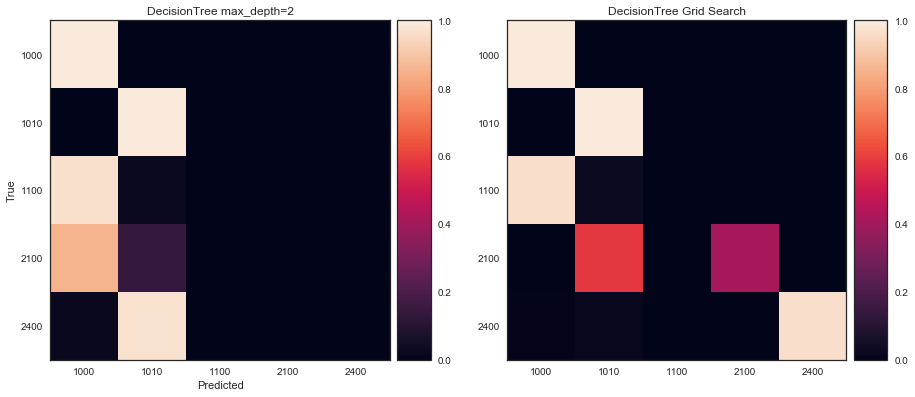

In [90]:
make_cms(dtree1_cm,dtree2_cm,'DecisionTree max_depth=2','DecisionTree Grid Search',labelsCM)

# 8) Random Forest classifier

### About Random Forests

The Random Forest Classifier is considered an ensemble algorithm. Ensemble algorithms combine more than one algorithm of same or different kind for classifying objects. The underlying concept for the Random Forest Classifier is the Decision Tree, which we explored above. Instead of just creating one decision tree, it creates a set of decision trees from randomly selected subset of training set. It then aggregates the votes from different decision trees to decide the final class of the test object. This way, the noise of a single decision tree is reduced. The parameters are similar to the decision tree, except that the number of trees need to be specified:


| Parameters       |Inputs| What they do        |
| :-------------- |:-------------|:-------------| 
| n_estimators |integers|The number of trees that will be created. The default is 10| 

In [91]:
rf_pipe = make_pipeline(VarianceThreshold(), RandomForestClassifier(n_jobs=-1))
rf_params = {'randomforestclassifier__n_estimators' : [70, 80, 100],
             'randomforestclassifier__max_features' : [20, 15, 31, 'auto'],
             'randomforestclassifier__max_depth' : [5, 10, None]}
rf_grid_search = GridSearchCV(rf_pipe, rf_params, cv=3, scoring='accuracy', verbose=2)

In [92]:
rf_grid_search.fit(train_d, train_lab)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] randomforestclassifier__max_depth=5, randomforestclassifier__max_features=20, randomforestclassifier__n_estimators=70 
[CV]  randomforestclassifier__max_depth=5, randomforestclassifier__max_features=20, randomforestclassifier__n_estimators=70, total=   1.5s
[CV] randomforestclassifier__max_depth=5, randomforestclassifier__max_features=20, randomforestclassifier__n_estimators=70 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s


[CV]  randomforestclassifier__max_depth=5, randomforestclassifier__max_features=20, randomforestclassifier__n_estimators=70, total=   1.6s
[CV] randomforestclassifier__max_depth=5, randomforestclassifier__max_features=20, randomforestclassifier__n_estimators=70 
[CV]  randomforestclassifier__max_depth=5, randomforestclassifier__max_features=20, randomforestclassifier__n_estimators=70, total=   1.5s
[CV] randomforestclassifier__max_depth=5, randomforestclassifier__max_features=20, randomforestclassifier__n_estimators=80 
[CV]  randomforestclassifier__max_depth=5, randomforestclassifier__max_features=20, randomforestclassifier__n_estimators=80, total=   1.6s
[CV] randomforestclassifier__max_depth=5, randomforestclassifier__max_features=20, randomforestclassifier__n_estimators=80 
[CV]  randomforestclassifier__max_depth=5, randomforestclassifier__max_features=20, randomforestclassifier__n_estimators=80, total=   1.6s
[CV] randomforestclassifier__max_depth=5, randomforestclassifier__max_fe

[CV]  randomforestclassifier__max_depth=5, randomforestclassifier__max_features=auto, randomforestclassifier__n_estimators=80, total=   0.9s
[CV] randomforestclassifier__max_depth=5, randomforestclassifier__max_features=auto, randomforestclassifier__n_estimators=100 
[CV]  randomforestclassifier__max_depth=5, randomforestclassifier__max_features=auto, randomforestclassifier__n_estimators=100, total=   1.2s
[CV] randomforestclassifier__max_depth=5, randomforestclassifier__max_features=auto, randomforestclassifier__n_estimators=100 
[CV]  randomforestclassifier__max_depth=5, randomforestclassifier__max_features=auto, randomforestclassifier__n_estimators=100, total=   1.1s
[CV] randomforestclassifier__max_depth=5, randomforestclassifier__max_features=auto, randomforestclassifier__n_estimators=100 
[CV]  randomforestclassifier__max_depth=5, randomforestclassifier__max_features=auto, randomforestclassifier__n_estimators=100, total=   1.1s
[CV] randomforestclassifier__max_depth=10, randomfor

[CV]  randomforestclassifier__max_depth=10, randomforestclassifier__max_features=auto, randomforestclassifier__n_estimators=70, total=   1.1s
[CV] randomforestclassifier__max_depth=10, randomforestclassifier__max_features=auto, randomforestclassifier__n_estimators=70 
[CV]  randomforestclassifier__max_depth=10, randomforestclassifier__max_features=auto, randomforestclassifier__n_estimators=70, total=   1.0s
[CV] randomforestclassifier__max_depth=10, randomforestclassifier__max_features=auto, randomforestclassifier__n_estimators=70 
[CV]  randomforestclassifier__max_depth=10, randomforestclassifier__max_features=auto, randomforestclassifier__n_estimators=70, total=   1.4s
[CV] randomforestclassifier__max_depth=10, randomforestclassifier__max_features=auto, randomforestclassifier__n_estimators=80 
[CV]  randomforestclassifier__max_depth=10, randomforestclassifier__max_features=auto, randomforestclassifier__n_estimators=80, total=   1.8s
[CV] randomforestclassifier__max_depth=10, randomfo

[CV]  randomforestclassifier__max_depth=None, randomforestclassifier__max_features=31, randomforestclassifier__n_estimators=80, total=   5.0s
[CV] randomforestclassifier__max_depth=None, randomforestclassifier__max_features=31, randomforestclassifier__n_estimators=80 
[CV]  randomforestclassifier__max_depth=None, randomforestclassifier__max_features=31, randomforestclassifier__n_estimators=80, total=   5.3s
[CV] randomforestclassifier__max_depth=None, randomforestclassifier__max_features=31, randomforestclassifier__n_estimators=100 
[CV]  randomforestclassifier__max_depth=None, randomforestclassifier__max_features=31, randomforestclassifier__n_estimators=100, total=   6.5s
[CV] randomforestclassifier__max_depth=None, randomforestclassifier__max_features=31, randomforestclassifier__n_estimators=100 
[CV]  randomforestclassifier__max_depth=None, randomforestclassifier__max_features=31, randomforestclassifier__n_estimators=100, total=   6.1s
[CV] randomforestclassifier__max_depth=None, ra

[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:  5.5min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('variancethreshold', VarianceThreshold(threshold=0.0)), ('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,..._jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'randomforestclassifier__n_estimators': [70, 80, 100], 'randomforestclassifier__max_features': [20, 15, 31, 'auto'], 'randomforestclassifier__max_depth': [5, 10, None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=2)

In [93]:
rf_grid_search.best_params_

{'randomforestclassifier__max_depth': 10,
 'randomforestclassifier__max_features': 15,
 'randomforestclassifier__n_estimators': 70}

In [94]:
rf_grid_search.score(test_d, test_lab)

0.91746987951807224

In [100]:
rf_lab_pred = rf_grid_search.predict(test_d)

In [96]:
print(metrics.classification_report(test_lab, rf_lab_pred))

             precision    recall  f1-score   support

     1000.0       0.90      1.00      0.95     13224
     1010.0       0.98      1.00      0.99      3214
     1100.0       0.51      0.02      0.03      1503
     2100.0       0.86      1.00      0.92        12
     2400.0       1.00      0.99      0.99       307

avg / total       0.89      0.92      0.88     18260



In [97]:
rf_cm=metrics.confusion_matrix(test_lab, rf_lab_pred)

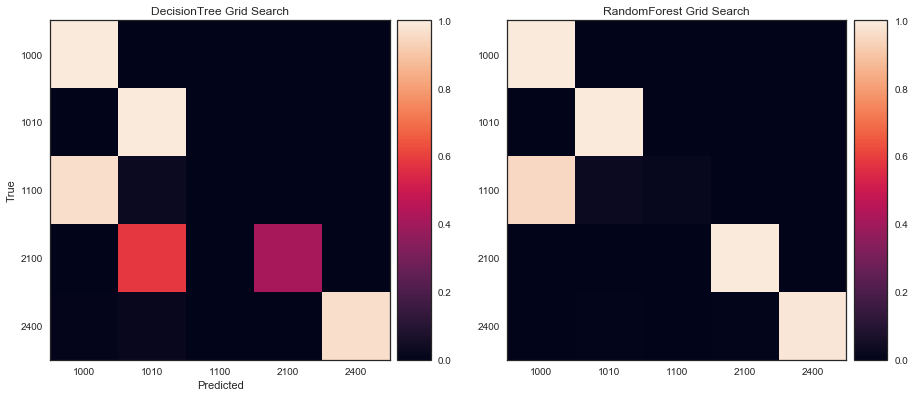

In [98]:
make_cms(dtree2_cm,rf_cm, 'DecisionTree Grid Search','RandomForest Grid Search',labelsCM)

# 9) Key findings

Reformat the results of selected classifiers:

In [276]:
#reset index of test data to merge
test_reindexed = test_d.reset_index(drop=True)

In [289]:
#merge predicted labels with test data knn
knn1_out = pd.merge(test_reindexed, pd.DataFrame(knn1_lab_pred),how='outer',left_index=True,right_index=True)
knn1_out.rename(columns={'0_y':'FUNC'}, inplace=True)
knn1_out=knn1_out[['DENS','RADR','FUNC']]

In [290]:
#merge predicted labels with test data knn2
knn2_out = pd.merge(test_reindexed, pd.DataFrame(knn2_lab_pred),how='outer',left_index=True,right_index=True)
knn2_out=knn2_out[['DENS','RADR','0_y']]

In [291]:
#merge predicted labels with test data decision tree
dtree_out = pd.merge(test_reindexed, pd.DataFrame(dtree2_lab_pred),how='outer',left_index=True,right_index=True)
dtree_out=dtree_out[['DENS','RADR','0_y']]

In [292]:
#merge predicted labels with test data random forest
rf_out = pd.merge(test_reindexed, pd.DataFrame(rf_lab_pred),how='outer',left_index=True,right_index=True)
rf_out=rf_out[['DENS','RADR','0_y']]

In [646]:
len(knn1_lab_pred)

18260

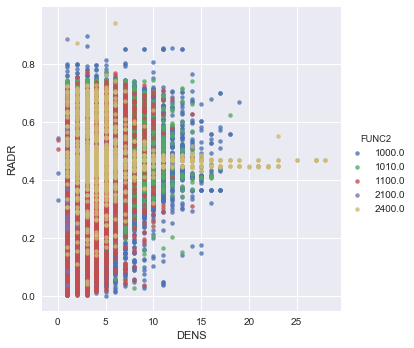

In [295]:
#plot original data
sns.lmplot('DENS', 
           'RADR', 
           data=buildings_agg, 
           fit_reg=False, # Don't fix a regression line
           hue="FUNC2",
           scatter_kws={"marker": "D", # Set marker style
                        "s": 20})  # S marker size

The predictions:

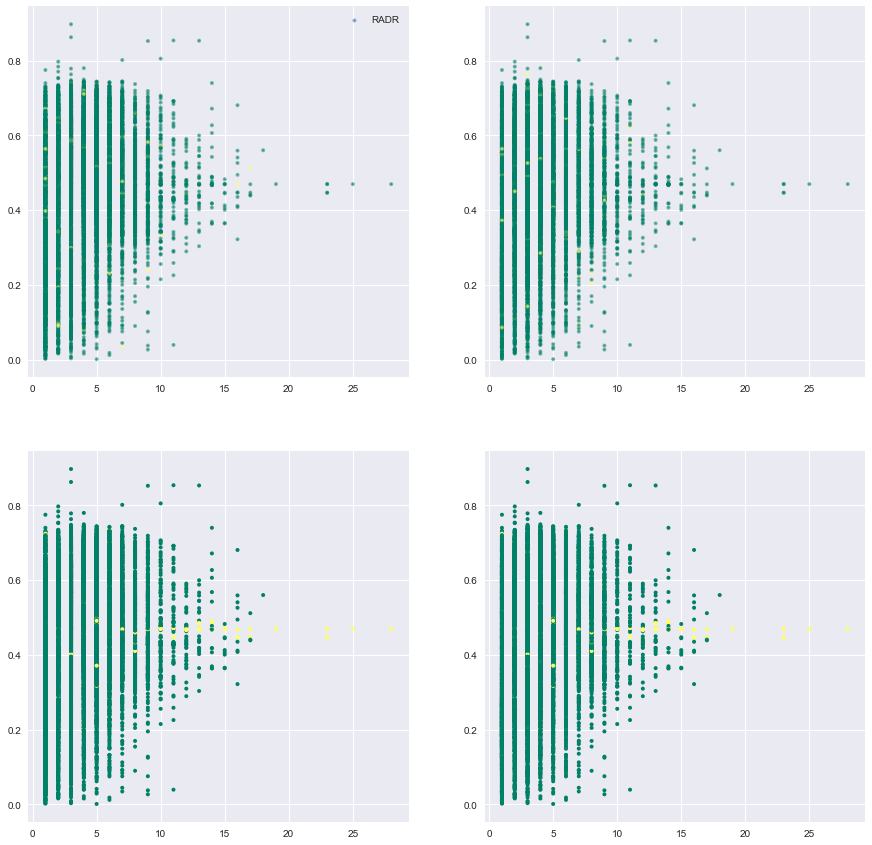

In [298]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(15,15))
ax1.scatter(x=knn1_out.DENS, y=knn1_out.RADR, s=4, linewidths=2, c=knn1_out.FUNC, cmap=plt.cm.summer, alpha=0.5)
ax2.scatter(knn2_out.DENS, knn2_out.RADR, s=4, linewidths=2, c=knn2_out['0_y'], cmap=plt.cm.summer, alpha=0.5)
ax3.scatter(dtree_out.DENS, dtree_out.RADR, s=4, linewidths=2, c=dtree_out['0_y'], cmap=plt.cm.summer)
ax4.scatter(rf_out.DENS, rf_out.RADR, s=4, linewidths=2, c=rf_out['0_y'], cmap=plt.cm.summer)
ax1.legend()
plt.show()

In [107]:
from sklearn.metrics import precision_recall_fscore_support

In [106]:
#create  a function to store results as a pandas dataframe:
def results_df(test, pred, labs):
    precision, recall, f_score, support = precision_recall_fscore_support(test,pred,labels=labs,average=None)
    results_pd = pd.DataFrame({"class": labels,
                               "precision": precision,
                               "recall": recall,
                               "f_score": f_score,
                               "support": support
                               })
    results_pd = results_pd.drop_duplicates(keep='first')
    results_pd =results_pd.reset_index(drop=True)
    return(results_pd)

### k-nearest Neighbors Classifier inital test run

In [116]:
results_df(test_lab,knn1_lab_pred,labels)

/Users/myveryself/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,class,f_score,precision,recall,support
0,1000.000,0.750,0.724,0.778,13224
1,1010.000,0.182,0.177,0.187,3214
2,1100.000,0.035,0.090,0.022,1503
3,2400.000,0.017,0.018,0.016,307
4,2100.000,0.000,0.000,0.000,12


### k-nearest Neighbors Classifier Grid Search

In [117]:
results_df(test_lab,knn1_gs_lab_pred,labels)

,class,f_score,precision,recall,support
0,1000.000,0.979,0.969,0.989,13224
1,1010.000,0.965,0.956,0.974,3214
2,1100.000,0.859,0.975,0.767,1503
3,2400.000,0.985,0.990,0.980,307
4,2100.000,0.909,1.000,0.833,12


### Decision Tree Classifier Grid Search

In [118]:
results_df(test_lab,dtree2_lab_pred,labels)

/Users/myveryself/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,class,f_score,precision,recall,support
0,1000.000,0.948,0.901,1.000,13224
1,1010.000,0.990,0.981,1.000,3214
2,1100.000,0.000,0.000,0.000,1503
3,2400.000,0.983,1.000,0.967,307
4,2100.000,0.588,1.000,0.417,12


### Random Forest Classifier Grid Search

In [119]:
results_df(test_lab,rf_lab_pred,labels)

,class,f_score,precision,recall,support
0,1000.000,0.948,0.902,0.998,13224
1,1010.000,0.992,0.985,1.000,3214
2,1100.000,0.031,0.511,0.016,1503
3,2400.000,0.992,0.997,0.987,307
4,2100.000,0.923,0.857,1.000,12


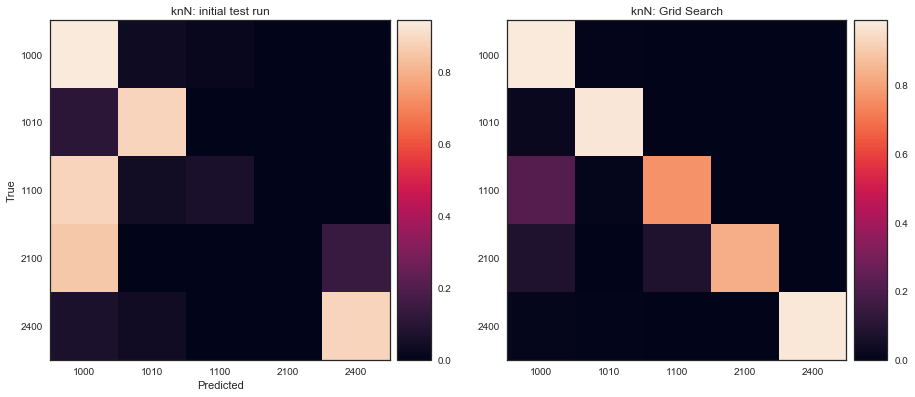

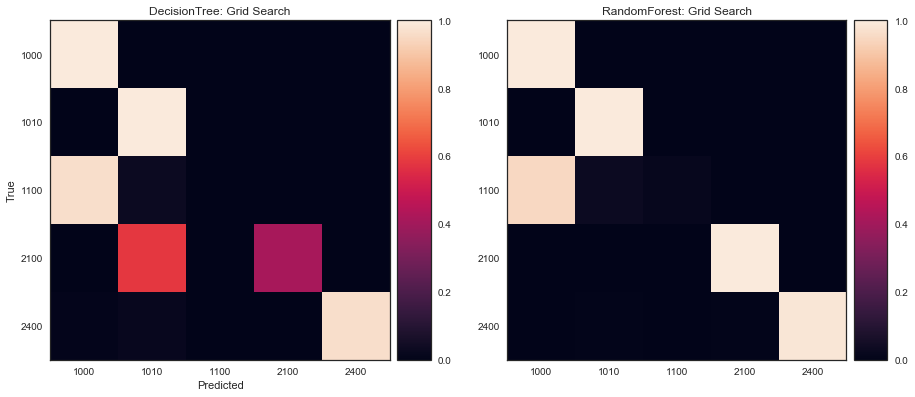

In [115]:
#show all confusion matrices:
make_cms(knn1_cm,knn1_gs_cm, 'knN: initial test run','knN: Grid Search',labelsCM)
make_cms(dtree2_cm,rf_cm, 'DecisionTree: Grid Search','RandomForest: Grid Search',labelsCM)

## 5.2) Overview f-scores for selected classifiers

### 1000: Residential Apartment Building: 
Highest f-score: **0.95**, Random Forest & Decision Tree <br>
Lowest f-score: **0.75**, k-nearest Neighbors with manual parameter settings

### 1010: Residential Single Family: 
Highest f-score: **0.99**, Random Forest <br>
Lowest f-score: **0.18**, k-nearest Neighbors with manual parameter settings

### 1100: Residential Mixed Use: 
Highest f-score: **0.86**, k-nearest Neighbors with hyperparametrization <br>
Lowest f-score: **0** (no predictions), Decision Tree Classifier

### 2100: Commerical Industrial: 
Highest f-score: **0.92**, Random Forest <br>
Lowest f-score: **0** (no predictions), k-nearest Neighbors with manual parameter settings

### 2400: Infrastructure: 
Highest f-score: **0.99**, k-nearest Neighbors with hyperparametrization <br>
Lowest f-score: **0.02**, k-nearest Neighbors with manual parameter settings

It can be said that predicting building types based on geometry features and year built is generally possible.
The comparison suggests that the Random Forest Classifier is the most suitable classification algorithm for building types based on geometry features and year built. However, all classification methods appear to be biased towards the overrepresented sample of the Residential Apartment Buildings (1000). This is particularly evident when looking at the classification of Residential Mixed Use (1100). In the initial analysis (See boxplots) it can be seen that little distinguishes this building type from the Residential Apartment Buildings (1000). Therefore, we can assume that the commerical functions have little impact on the geometry of the buildings. All classifiers perform reasonably well on the Commerical Industrial building class (2100) and the Infrastructural buildings (2400), depite the smaller sample sizes of 112 samples and 1786 samples, respectively.


The key challenge in supervised building type classification is the unbalanced sample, which is in the nature of the object we are studying. By aggregating the function to larger groups, information is lost.
Instead of articifially downsampling the large residential share of the data, we might find other ways to subset the data. To further investigate the nature of geometry features, it might be interesting to apply unsupervised methods, such as clustering (Steiniger et al, 2008). It is worth noting that typologies depend on the cultural context. The finding of this analysis therefore might only apply to the City of Hamburg or another European city but most likely will not be valid for cities elsewhere. In a further step, other city footprints could be analyzed and compared.

# 10) References

Wurm, M., Schmitt, A., Taubenböck, H. (2016). **Building Types’ Classification Using Shape-Based Features and Linear Discriminant Functions.** IEEE Journal of selected topics in applied earth observations and remote sensing.
https://ieeexplore.ieee.org/document/7210144/

Steiniger, S., Lange, T., Burghardt, D., Weibel, R. (2008). **An Approach for the Classification of Urban Building Structures Based on Discriminant Analysis Techniques.** Transactions in GIS, 12(1) https://onlinelibrary.wiley.com/doi/abs/10.1111/j.1467-9671.2008.01085.x

Signorelli, V., Leduc, T. (2016). **Utilisation du socle 3D CityGML Nantes - Secteur centre-ville**. HAL-archives ouvertes

Freie und Hansestadt Hamburg. (2011). **Arbeitshinweise zur Führung der Objektaritenbereichs 'Gebäude' im ALKIS**. https://www.hamburg.de/bsw/ueber-uns-lgv/8207680/fachliche-anweisungen/

Python Modules: **Scikit-learn - Machine Learning in Python.** http://scikit-learn.org/stable/

Dataset (GML): **ALKIS Liegenschaftskarte - ausgewählte Daten Hamburg.** http://suche.transparenz.hamburg.de/dataset/alkis-liegenschaftskarte-ausgewahlte-daten-hamburg15?forceWeb=true

On crossvalidation: http://scikit-learn.org/stable/modules/cross_validation.html

On choosing the right algorithm: http://scikit-learn.org/stable/tutorial/machine_learning_map/index.html

Good tutorial: https://www.oreilly.com/ideas/intro-to-scikit-learn